In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
%matplotlib inline
import string

def softmax(arr):
    return np.exp(arr) / np.sum(np.exp(arr))

# Corpus parameters
K = 2
xi = 1000 # Approximate number of words
T = 20
V = 10
var_init = 1
var_basic = 0.1

# Initialise the vocabulary
vocab = []
for w in range(V):
    vocab.append(string.ascii_lowercase[w])

prior_dirichlet = np.repeat(1./V, V)
beta = np.random.dirichlet(prior_dirichlet, K)
beta = np.array([[0, 0, 0, 0.3, 0.7, 0, 0, 0, 0, 0], [0, 0, 0.2, 0, 0, 0, 0, 0.3, 0.3, 0.2]])
# print beta[0].sum()
alphas = np.zeros((T, K))
linspace_4pi = np.linspace(0, 4*np.pi, num=T)
alphas[:,0] = np.sin(linspace_4pi) 
alphas[:,1] = np.cos(linspace_4pi) 

corpus = {}
for d in range(T):
    corpus[d] = {}
    N = np.random.poisson(xi)
    for w in range(N):
#         eta = softmax(alphas[d])
#         topic_distrib = np.random.multinomial(1, eta)
        topic_distrib = np.random.multinomial(1, alphas[d])
        z = np.where(topic_distrib == 1)[0][0]
        word_distrib = np.random.multinomial(1, beta[z])
        w = np.where(word_distrib == 1)[0][0]
        w_key = vocab[w]
        if w_key not in corpus[d]:
            corpus[d][w_key] = 0
        corpus[d][w_key] += 1

from preprocessing import preprocess_corpus
count_max = 200.
normalise = False
corpus = preprocess_corpus(corpus, vocab, threshold=count_max, normalise=normalise)

[(0.0, 'a'), (1.0, 'b'), (2.0, 'c'), (3.0, 'd'), (4.0, 'e'), (5.0, 'f'), (6.0, 'g'), (7.0, 'h'), (8.0, 'i'), (9.0, 'j')]


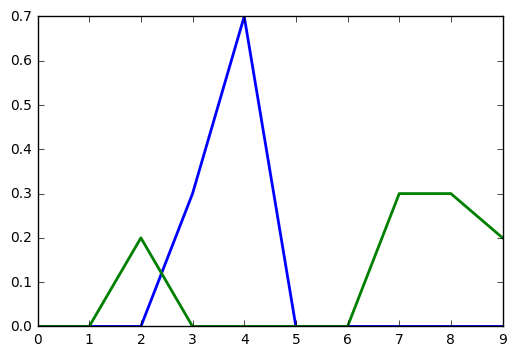

In [2]:
# Plot betas
linspace_V = np.linspace(0, V-1, num=V)
plt.plot(linspace_V, beta[0], linewidth=2)
plt.plot(linspace_V, beta[1], linewidth=2)
print zip(linspace_V, vocab)

In [62]:
from dtm_alpha import DTM_alpha

iter_count = 2000
var_init = 10
var_basic = 0.1
var_prop = 0.5

dtm_alpha = DTM_alpha(K=K, iter_count=iter_count, var_init=var_init, var_basic=var_basic, var_prop=var_prop)
dtm_alpha.beta = beta
dtm_alpha.fit(corpus)

history_alpha = dtm_alpha.history_alpha

Iteration: 10
Total alpha changes: 82
Alpha update rate: 0.4100
Iteration: 20
Total alpha changes: 152
Alpha update rate: 0.3800
Iteration: 30
Total alpha changes: 206
Alpha update rate: 0.3433
Iteration: 40
Total alpha changes: 235
Alpha update rate: 0.2938
Iteration: 50
Total alpha changes: 260
Alpha update rate: 0.2600
Iteration: 60
Total alpha changes: 279
Alpha update rate: 0.2325
Iteration: 70
Total alpha changes: 309
Alpha update rate: 0.2207
Iteration: 80
Total alpha changes: 335
Alpha update rate: 0.2094
Iteration: 90
Total alpha changes: 355
Alpha update rate: 0.1972
Iteration: 100
Total alpha changes: 371
Alpha update rate: 0.1855
Iteration: 110
Total alpha changes: 390
Alpha update rate: 0.1773
Iteration: 120
Total alpha changes: 407
Alpha update rate: 0.1696
Iteration: 130
Total alpha changes: 432
Alpha update rate: 0.1662
Iteration: 140
Total alpha changes: 453
Alpha update rate: 0.1618
Iteration: 150
Total alpha changes: 475
Alpha update rate: 0.1583
Iteration: 160
Total

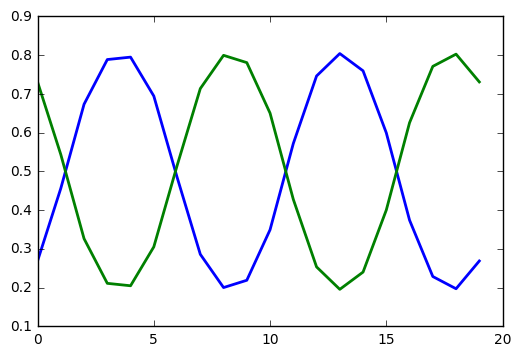

In [63]:
# Plot alphas
linspace_t = np.linspace(0, T-1, num=T)
alphas_softmax = np.zeros(shape=alphas.shape)
for t, alpha_t in enumerate(alphas):
    alphas_softmax[t] = softmax(alpha_t)
plt.plot(linspace_t, alphas_softmax, linewidth=2)

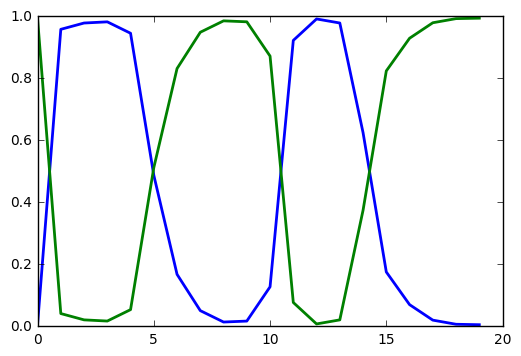

In [64]:
alphas_last_proposed = history_alpha[iter_count-1]
alphas_softmax_last_proposed = np.zeros(shape=alphas_last_proposed.shape)
for t, alphas_last_proposed_t in enumerate(alphas_last_proposed):
    alphas_softmax_last_proposed[t] = softmax(alphas_last_proposed_t)
plt.plot(linspace_t, alphas_softmax_last_proposed, linewidth=2)
# plt.plot(linspace_t, history_alpha[iter_count-1], linewidth=2)
plt.savefig('results/var-init-%.1f_var-prop%.1f_iter%d.png' % (var_init, var_prop, iter_count))

In [65]:
import plotly.plotly as py
from plotly.graph_objs import Surface
import plotly.graph_objs as go

alphas_softmax_proposed = np.zeros(shape=history_alpha.shape)

diff_min = 10000
idx_min = -1
for it, alpha_it in enumerate(history_alpha):
    for t, alpha_proposed_t in enumerate(alpha_it):
        alphas_softmax_proposed[it][t] = softmax(alpha_proposed_t)
    diff_abs = np.abs(alphas_softmax - alphas_softmax_proposed[it]).sum()
    if diff_abs < diff_min:
        diff_min = diff_abs
        idx_min = it
    print np.abs(alphas_softmax - alphas_softmax_proposed[it]).sum()
    
n_alphas = alphas_softmax_proposed.shape[2]
list_alphas = []
for i in range(n_alphas):
    alpha = dict(z = alphas_softmax_proposed[:, :, i], type='surface')
    list_alphas.append(alpha)
fig = go.Figure(data=list_alphas)

# py.iplot(fig)

20.4601961786
20.4588444766
20.456805729
20.4545116831
20.4511149452
20.4447517507
20.4367531026
20.4274459672
20.3881138887
20.3624122553
20.3079864124
20.2650649459
20.2163899629
20.1079780009
20.0623770802
19.9894557429
19.6796657897
19.4569995559
19.1974806835
18.8763450621
18.3748327371
17.8808643698
16.2632465952
15.5524067033
14.6113459259
13.3495481281
12.3218896629
11.5857465633
10.9696912263
10.2499977874
9.66059513425
9.04502331362
8.07827254287
8.04595416224
7.57778488268
7.57778488268
7.99231399217
8.12481143924
8.06398128405
7.96070279716
8.35434368349
8.28169120523
8.24334492362
8.34153278842
7.93626792122
7.93645480754
8.04772298768
8.0818420721
7.81524063332
7.9476321174
8.06352675062
7.83258936935
7.88404283273
7.88404283273
7.75986094175
7.79685925677
7.82454913023
7.9972938312
7.52560223004
7.54005382304
7.50312031536
7.38890136693
7.10148712305
6.9873942142
7.0999180211
7.16065246524
7.17485640435
7.061492787
7.07984312048
6.97299813994
6.91030980045
7.21042201025


In [66]:
print diff_min
print idx_min

6.91030980045
70


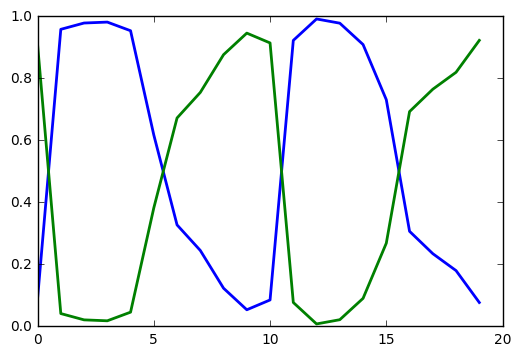

In [67]:
alphas_last_proposed = history_alpha[idx_min]
alphas_softmax_last_proposed = np.zeros(shape=alphas_last_proposed.shape)
for t, alphas_last_proposed_t in enumerate(alphas_last_proposed):
    alphas_softmax_last_proposed[t] = softmax(alphas_last_proposed_t)
plt.plot(linspace_t, alphas_softmax_last_proposed, linewidth=2)
# plt.plot(linspace_t, history_alpha[iter_count-1], linewidth=2)
plt.savefig('results/var-init-%.1f_var-prop-%.1f_it-total-%d_it-min-%d.png' % (var_init, var_prop, iter_count, idx_min))